[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Azie88/Coachella-Tweet-Sentiment-Analysis/blob/main/Sentiment_Analysis_Coachella.ipynb)


# Sentiment Analysis Using Colab and Huggingface

What's Deep Learning? It is machine learning based on artificial neural networks in which multiple layers of processing are used to extract progressively higher level features from data.

In this project, we will fine-tune a pre-trained Deep Learning model from HuggingFace on a new dataset ([Coachella 2015 tweet sentiment](https://https://www.kaggle.com/datasets/thedevastator/twitter-sentiment-analysis-coachella-festival)) to adapt the model to our sentiment analysis task, then create an app to use the model and deploy the app on the HuggingFace platform.

## Install Libraries and Packages

In [1]:
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

## Import Libraries and Packages

In [2]:
#System and data handling
import os
import re
import warnings
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np

#Data Analysis & Preparation
from evaluate import load
from collections import Counter
from datasets import Dataset, DatasetDict


#Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

#Google Drive
from google.colab import drive

#Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, TFAutoModelForSequenceClassification

#Scores
from scipy.special import softmax

# Deep learning
import torch
from torch import nn

#Huggingface
from huggingface_hub import notebook_login

## Setup

In [3]:
# Set a fixed random seed for PyTorch on CPU
torch.manual_seed(42)

# Control the seed for individual GPU operations (optional)
if torch.cuda.is_available:
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed_all(42)


In [4]:
# Set CUDA_LAUNCH_BLOCKING for debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## Connect to Google Drive & Load Dataset

In [5]:
# Connect to your google drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/Coachella-2015-2-DFE.csv', encoding='latin-1')

## Data Understanding

In [7]:
#look at first 5 rows in train data
df.head()

,coachella_sentiment,coachella_yn,name,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,positive,yes,kokombil,0,#Coachella2015 tickets selling out in less than 40 minutes _Ù_¦_Ù___Ù___Ù÷_ÙÎµ_ÙÎµ_Ù___Ù_¦ http://t.co/SmoXyteIMJ,"[0.0, 0.0]",1/7/15 15:02,5.529630e+17,NaN,Quito
1,positive,yes,MisssTaraaa10,2,RT @sudsybuddy: WAIT THIS IS ABSOLUTE FIRE _ÙÓ´_ÙÓ´_ÙÓ´ #Coachella2015 http://t.co/Ov2eCJtAvR,NaN,1/7/15 15:02,5.529630e+17,united states,NaN
2,positive,yes,NMcCracken805,0,#Coachella2015 #VIP passes secured! See you there bitchesssss,NaN,1/7/15 15:01,5.529630e+17,"Costa Mesa, CA",NaN
3,positive,yes,wxpnfm,1,PhillyÛªs @warondrugsjams will play #Coachella2015 &amp; #GovBall2015! Watch them on Jimmy Fallon: http://t.co/wzaAE5wYNT http://t.co/sFL9I5sD20,NaN,1/7/15 15:01,5.529630e+17,"Philadelphia, PA and Worldwide",Quito
4,positive,yes,Caesears,0,If briana and her mom out to #Coachella2015 im out with them !!! _Ù÷Ý_Ù÷Ý_Ù÷Ý_ÙÕÄ,NaN,1/7/15 15:00,5.529630e+17,NaN,NaN


In [8]:
df.shape

(3846, 10)

In [9]:
df.dtypes

,0
coachella_sentiment,object
coachella_yn,object
name,object
retweet_count,int64
text,object
tweet_coord,object
tweet_created,object
tweet_id,float64
tweet_location,object
user_timezone,object


In [10]:
df.isna().sum()

,0
coachella_sentiment,0
coachella_yn,0
name,0
retweet_count,0
text,0
tweet_coord,3604
tweet_created,0
tweet_id,0
tweet_location,1170
user_timezone,983


In [11]:
df.coachella_sentiment.value_counts()

,count
coachella_sentiment,
positive,2283
neutral,928
negative,553
cant tell,82


In [12]:
df.text.sample(10)

,text
719,@Lights at #Coachella2015 makes me wish i was going even more. I love @Lights
3270,@coachella i dont see @CalvinHarris in your lineup? #Coachella2015 #CoachellaNeedsCalvin
696,For some awesome reason! Listening to AC_ÁüDC at the gym now pumps me up so much more!!! #Coachella2015
131,i got my coachella ticket!! VIP doe #Coachella2015 #Coachella2015
2304,RT @LANGMarMendoza: Check out how social media reacted to #Coachella2015 tickets selling out in less than 40 minutes http://t.co/jb74ZsuE2kÛ_
3791,RT @AniCaribbean: That #Coachella2015 lineup tho http://t.co/lBA0aKzm4g
3456,"This years Coachella performers are okay you have the weekend,drake,Marian and diamonds but where is Lana del Rey?? _Ù÷Á#Coachella2015"
1097,"Interpol, I'm going for Interpol... #Coachella2015"
499,RT @IAMATRK: They released the @coachella #Coachella2015 #coachellalineup _Ù÷©_Ù÷©_Ù÷©_Ù÷© omg I wanna go now !!! http://t.co/tRFQdX6scn
3256,not really upset about the #coachella2015 lineup. it gives me a chance to find more favorite artists.


## Data Preparation

1. Drop all unnecessary columns
2. Rename *coachella_sentiment* column to *labels*
3. Remove rows with *'can't tell'* sentiment values.
4. Clean *text* column of Twitter Handles, HTML characters, URLs and other non alphabetic characters. Text is inconsistent and may affect model performance.


In [13]:
# Drop unused columns

cols_to_drop = [
    'coachella_yn', 'name', 'retweet_count', 'tweet_coord',
    'tweet_id', 'user_timezone', 'tweet_location', 'tweet_created'
]
df = df.drop(columns=cols_to_drop)

In [14]:
df.head(10)

,coachella_sentiment,text
0,positive,#Coachella2015 tickets selling out in less than 40 minutes _Ù_¦_Ù___Ù___Ù÷_ÙÎµ_ÙÎµ_Ù___Ù_¦ http://t.co/SmoXyteIMJ
1,positive,RT @sudsybuddy: WAIT THIS IS ABSOLUTE FIRE _ÙÓ´_ÙÓ´_ÙÓ´ #Coachella2015 http://t.co/Ov2eCJtAvR
2,positive,#Coachella2015 #VIP passes secured! See you there bitchesssss
3,positive,PhillyÛªs @warondrugsjams will play #Coachella2015 &amp; #GovBall2015! Watch them on Jimmy Fallon: http://t.co/wzaAE5wYNT http://t.co/sFL9I5sD20
4,positive,If briana and her mom out to #Coachella2015 im out with them !!! _Ù÷Ý_Ù÷Ý_Ù÷Ý_ÙÕÄ
5,positive,West side is the best side!\n#west #coas #Coachella2015 http://t.co/BhasNazMMU
6,positive,Coachella tickets are now sold out _Ù÷_ &amp; I had the opportunity to have bought them. I'm definitely going next year #Coachella2015 #Coachella
7,positive,#Coachella2015 I absolutely can NOT wait. This weekend is about to exceed EPIC EXPECTATIONS!!! :) Lineup is CRAZY! http://t.co/7CQXKCprLH
8,positive,If someone got me to Coachella if be your friend for life #truth #desprate #Coachella2015 #Coachella http://t.co/MMDkTMOZfW
9,positive,RT @brownjenjen:  Õ http://t.co/mxCREvIlGP 712 Coachella 2015 Coachella 2015 makes space for rockers and ravers this year #Coachella2015 OhÛ_


In [15]:
df.rename(columns={'coachella_sentiment': 'labels'}, inplace=True)

In [16]:
#Remove rows with 'can't tell' sentiment values
df = df[df['labels'] != 'cant tell']

In [17]:
df.labels.value_counts()

,count
labels,
positive,2283
neutral,928
negative,553


In [18]:
def clean_text(text):
    # Convert text to lower case
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove tweet mentions
    text = re.sub(r'<user>', '', text)
    text = re.sub(r'<url>', '', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Replace all whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text)

    # Remove leading and trailing whitespace
    text = text.strip()

    return text

In [19]:
# Apply the clean_text function to the 'text' column
df['text'] = df.text.apply(clean_text)

In [20]:
df.sample(10)

,labels,text
1456,positive,the techno and house at coachella is begging me to attend i have my pass but still deciding thought i had butthat techno
1737,positive,grab those flower crowns the coachella lineup is here amp yes were freaking a little
3252,negative,someone purchase my coachella tickets i dont have time to wait for this shit
574,positive,who really going to coachella though cus im forreal bout it boutta buy my tickets tomorrow
3195,neutral,rt irwinelgrande coachella lineup preview coachella coachella coachellalineup
915,positive,not bad at all coachella
1074,positive,im trynna break my coachella virginity coachella
2529,neutral,rt mileycyrusph miley is attending amp getting ready for coachella
727,positive,so how about that coachella lineup perhaps the best ever
498,positive,love the coachella line up coachellalineup coachella coachella


## Exploratory Data Analysis

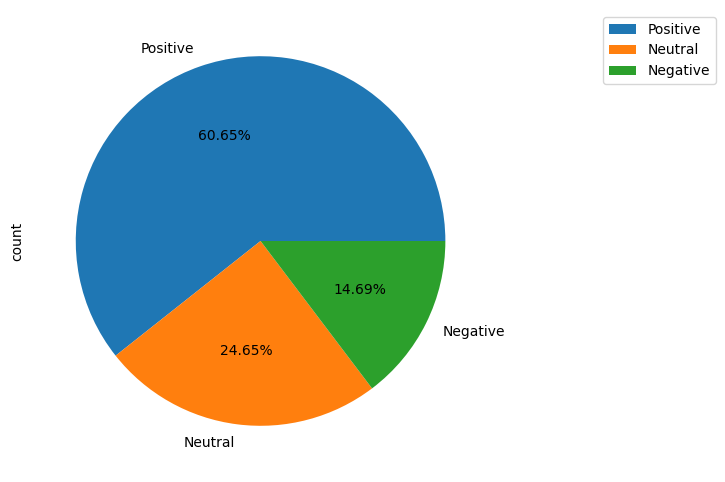

In [21]:
# pie chart with 'labels' column
plt.figure(figsize=(6,6))
explode=0.1,0
df.labels.value_counts().plot.pie(autopct='%1.2f%%',labels=['Positive','Neutral','Negative'])
plt.legend(bbox_to_anchor=(1.5,1))
plt.show()

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

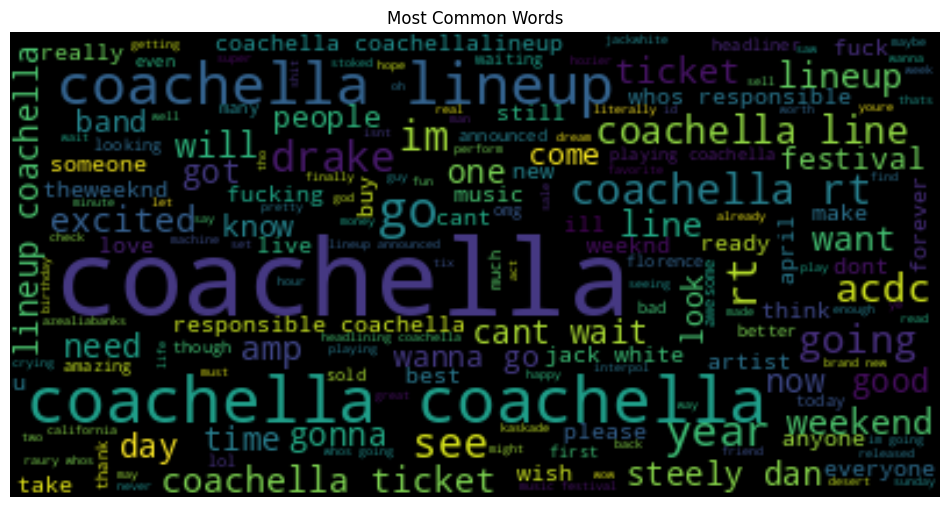

In [22]:
# Word Cloud
all_data = df['text'].to_string()
wordcloud = WordCloud().generate(all_data)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.title('Most Common Words')
plt.axis("off")

In [23]:
# Word Count - Top 20 most common words
temp_list = df['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in temp_list for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,coachella,4854
1,to,1356
2,the,1298
3,i,955
4,lineup,725
5,is,721
6,and,573
7,rt,518
8,for,513
9,this,426


In [24]:
text_lengths = df['text'].str.split().str.len()
text_lengths.value_counts().sort_values(ascending=False)

,count
text,
7,310
6,263
9,262
5,256
10,246
8,243
12,212
13,210
11,201


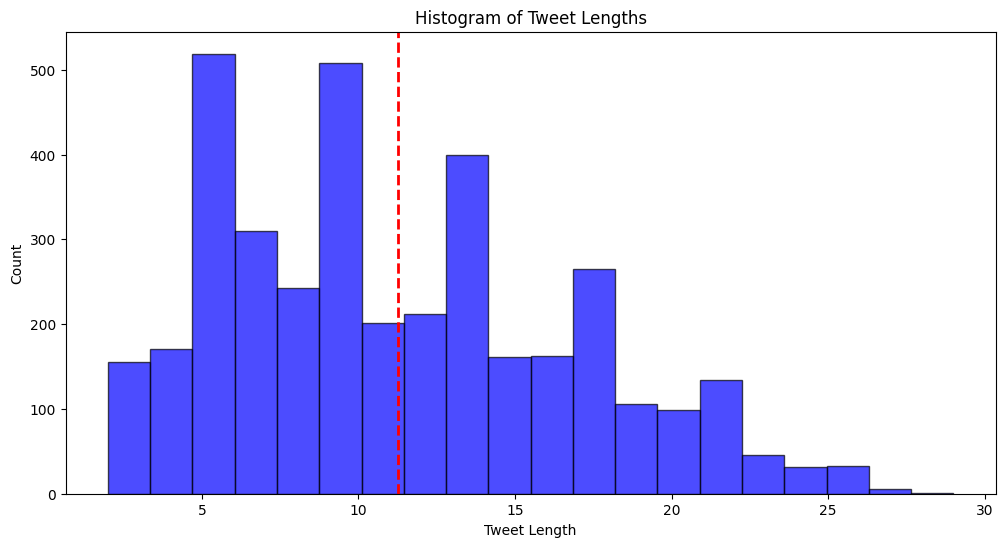

In [25]:
# Calculate the average
average_length = np.mean(text_lengths)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Using plt.hist to create a histogram with Matplotlib
ax.hist(text_lengths, bins=20, color="blue", edgecolor="black", alpha=0.7)

# Add average line
ax.axvline(average_length, color='red', linestyle='dashed', linewidth=2, label=f'Average: {average_length:.2f}')

ax.set_title('Histogram of Tweet Lengths')
ax.set_xlabel('Tweet Length')
ax.set_ylabel('Count')

# Display the plot
plt.show()

## Train Test Split

In [26]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

In [27]:
train.head()

,labels,text
3469,negative,i wish incubus or sonsofthesea would have been on the coachella lineup
2956,neutral,eric this is hilareous haha thatericalper this faux coachella lineup from coachella coachella
3584,negative,gotta get my abs back for coachella but i love eating and sleeping way too much
3296,negative,i hope it rains during drakes coachella set so everyone can talk about how they bathed in drakes tears coachella
1011,positive,omg the coachella lineup soexcited


In [28]:
eval.head()

,labels,text
1576,positive,everyone is talking about the nflplayoffs and im just praying to see tupac at coachella rip
3577,negative,ok back to oogling and crying at this lineup tt coachella
726,positive,bring it coachella have my artist pass amp room ready to go
3197,neutral,coachella lineup preview coachella coachella coachellalineup
1,positive,rt sudsybuddy wait this is absolute fire coachella


In [29]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (3011, 2), eval is (753, 2)


In [30]:
# Save split subsets
train.to_csv("/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/train_subset.csv", index=False)
eval.to_csv("/content/drive/MyDrive/Sentiment Analysis NLP/Dataset/eval_subset.csv", index=False)

## Model Training and Fine Tuning

In [31]:
#login to huggingface with access token

notebook_login()

In [33]:
warnings.filterwarnings("ignore", category=FutureWarning)

roberta = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(roberta)

## Label and Text Processing

In [34]:
# Function to tokenize data

def tokenize_data(example):
    return tokenizer(example['text'], max_length = 128, padding='max_length', truncation=True)

In [35]:
def transform_labels(labels):

    labels = labels['labels']
    num = 0
    if labels == 'negative':
        num = 0
    elif labels == 'neutral':
        num = 1
    elif labels == 'positive':
        num = 2

    return {'labels': num}

In [36]:
# Convert dataframes to datasets objects
train_dataset = Dataset.from_pandas(train)
eval_dataset = Dataset.from_pandas(eval)

# Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'eval': eval_dataset
})

In [37]:
# Change the tweets to tokens that the model can use and remove the original columns

dataset = dataset.map(tokenize_data, batched=True)

remove_columns = ['labels', 'text']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/3011 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/3011 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

In [38]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 3011
    })
    eval: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 753
    })
})

In [39]:
remove_columns = ['__index_level_0__']
dataset = dataset.map(remove_columns=remove_columns)

Map:   0%|          | 0/3011 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

In [40]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3011
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 753
    })
})

### Balancing Target Classes

Since our target has imbalanced class weights (positive, neutral and negative dont have an equal number of samples), we want to give more weight to underrepresented classes and give less weight to classes with more samples.

In [41]:
# Define the labels
labels = dataset['train']['labels']

# Apply the compute class weight function to calculate the class weight
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

The `balanced` option in compute_class_weight will calculate weights such that the classes are balanced.

In [42]:
# Preview class weights
class_weights, np.unique(labels)

(array([2.26561324, 1.35265049, 0.54965316]), array([0, 1, 2]))

### Initialize pre-trained model

In [43]:
# Define an instance of the pre-trained model with the number of labels
model = AutoModelForSequenceClassification.from_pretrained(roberta, num_labels=3)

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Configure Training Parameters

In [51]:
# Configure the training parameters

training_args = TrainingArguments("./results",
    report_to = "none",
    num_train_epochs=3, # the number of times the model will repeat the training loop over the dataset
    load_best_model_at_end=True,
    eval_strategy='epoch',
    save_strategy='epoch',
)

In [52]:
# evaluation metrics
metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Define Custom Trainer

In [53]:
# Convert train data to PyTorch tensors to speed up training and add padding
#data_collator = DataCollatorWithPadding(tokenizer=tokenizer,padding=True, max_length='max_length', return_tensors='pt')

In [54]:
# Define Custom Trainer | Modify loss function and assign computed weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Ensure logits and labels have compatible shapes and labels are of integer type
        #assert logits.shape[1] == self.model.config.num_labels, f"Logits shape {logits.shape} does not match number of labels {self.model.config.num_labels}"
        #assert labels.max() < self.model.config.num_labels, f"Labels contain values outside the valid range: {labels}"
        #assert labels.dtype == torch.long, f"Labels must be of type torch.long, but got {labels.dtype}"

        # Apply Class Weights
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(model.device)

        # Compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

### Training and Evaluation

In [55]:
# Instantiate the training and validation sets with random state of 10
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

In [56]:
# Instantiate the trainer for training
c_trainer = CustomTrainer(
                  model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  tokenizer = tokenizer,
                  compute_metrics=compute_metrics,
)

In [57]:
# Launch the learning process: training
c_trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Launch the final evaluation
c_trainer.evaluate()

{'eval_loss': 0.7405956387519836,
 'eval_accuracy': 0.6972111553784861,
 'eval_runtime': 5.9265,
 'eval_samples_per_second': 127.057,
 'eval_steps_per_second': 16.03,
 'epoch': 5.0}

In [ ]:
# Push model and tokenizer to HF Hub
model.push_to_hub("Azie88/Coachella_sentiment_analysis_roberta")
tokenizer.push_to_hub("Azie88/Coachella_sentiment_analysis_roberta")
dataset.push_to_hub("Azie88/Coachella_sentiment_analysis_roberta")

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

## Inference
Let's test out our model with with some sample text

In [ ]:
model_path = f"Azie88/Coachella_sentiment_analysis_roberta"

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
# Input preprocessing
text = "that saturday lineup is fire, except for Jack White"
text = preprocess(text)

In [ ]:
# PyTorch-based models
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [ ]:
print("Scores:", scores)
print("id2label Dictionary:", config.id2label)

In [ ]:
config.id2label = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

In [ ]:
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")